In [789]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler , LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score, roc_curve,ConfusionMatrixDisplay,silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans , DBSCAN
from itertools import combinations
from sklearn.decomposition import PCA

In [790]:
df = pd.read_csv('Country-data.csv')

In [791]:
df.sample(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
140,Sri Lanka,11.2,19.6,2.94,26.8,8560,22.80,74.4,2.20,2810
71,Iran,19.3,24.4,5.60,19.4,17400,15.90,74.5,1.76,6530
44,Denmark,4.1,50.5,11.40,43.6,44000,3.22,79.5,1.87,58000
21,Botswana,52.5,43.6,8.30,51.3,13300,8.92,57.1,2.88,6350
116,Pakistan,92.1,13.5,2.20,19.4,4280,10.90,65.3,3.85,1040


In [792]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [793]:
df.select_dtypes(exclude='object').describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [794]:
df.select_dtypes(include='object').describe()

,country
count,167
unique,167
top,Afghanistan
freq,1


In [795]:
df.shape

(167, 10)

In [796]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [797]:
df.drop('country' ,axis=1,inplace=True)

In [798]:
# sns.pairplot(df)
# plt.show()

<Axes: >

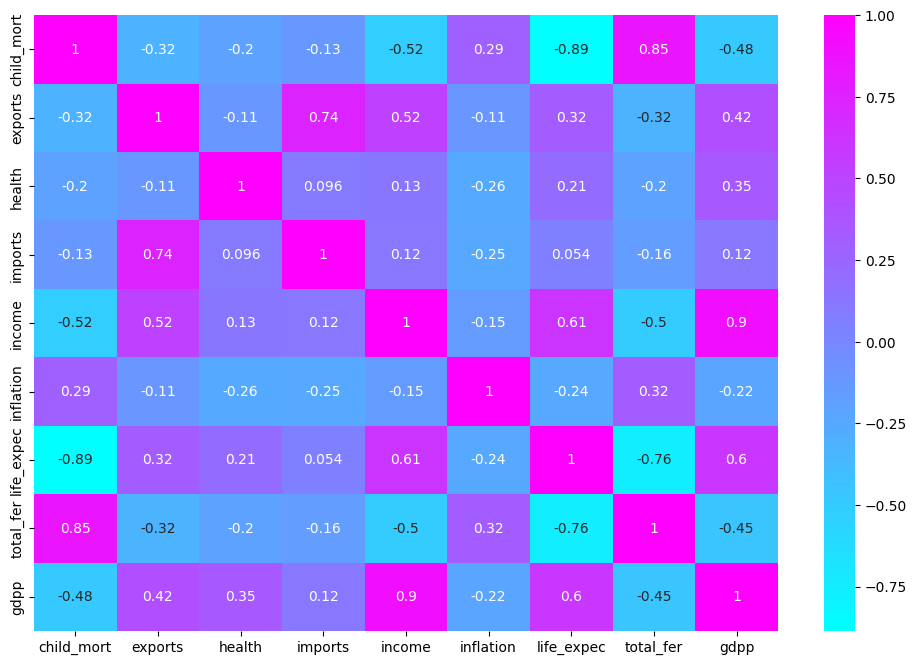

In [799]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr() , annot=True , cmap='cool')

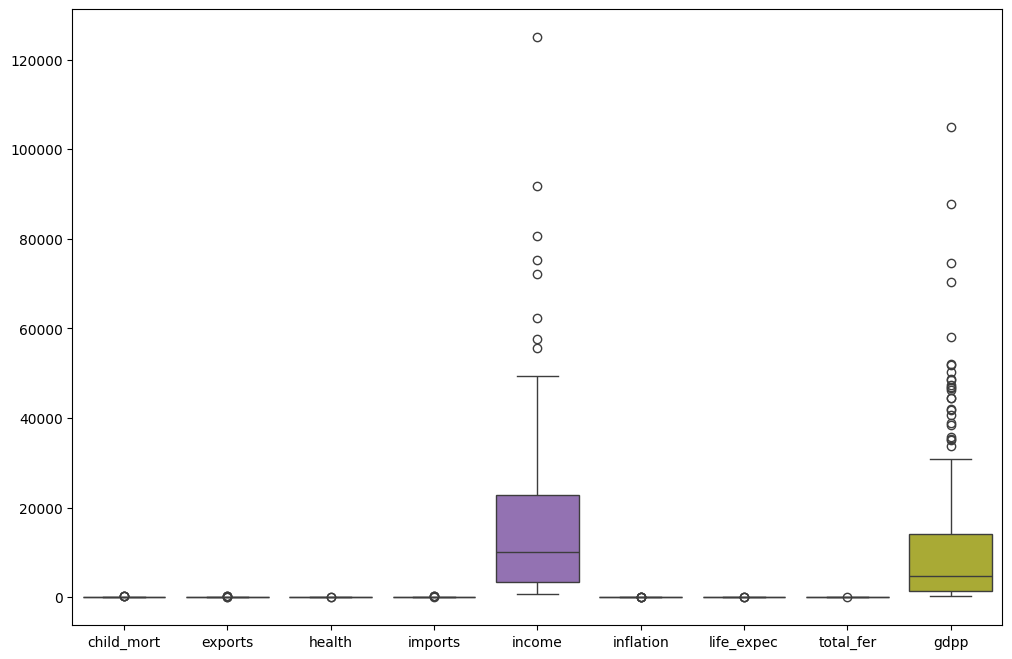

In [800]:
plt.figure(figsize=(12,8))
sns.boxplot(df)
plt.show()

In [801]:
# def remove_outliers_iqr(df):
#     df_clean = df.copy()
#     for col in df_clean.select_dtypes(include=np.number).columns:
#         Q1 = df_clean[col].quantile(0.25)
#         Q3 = df_clean[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
#     return df_clean

# df = remove_outliers_iqr(df)

In [802]:
st = MinMaxScaler()
df_scaled = st.fit_transform(df)

In [803]:
df = pd.DataFrame(df_scaled , columns=df.columns)

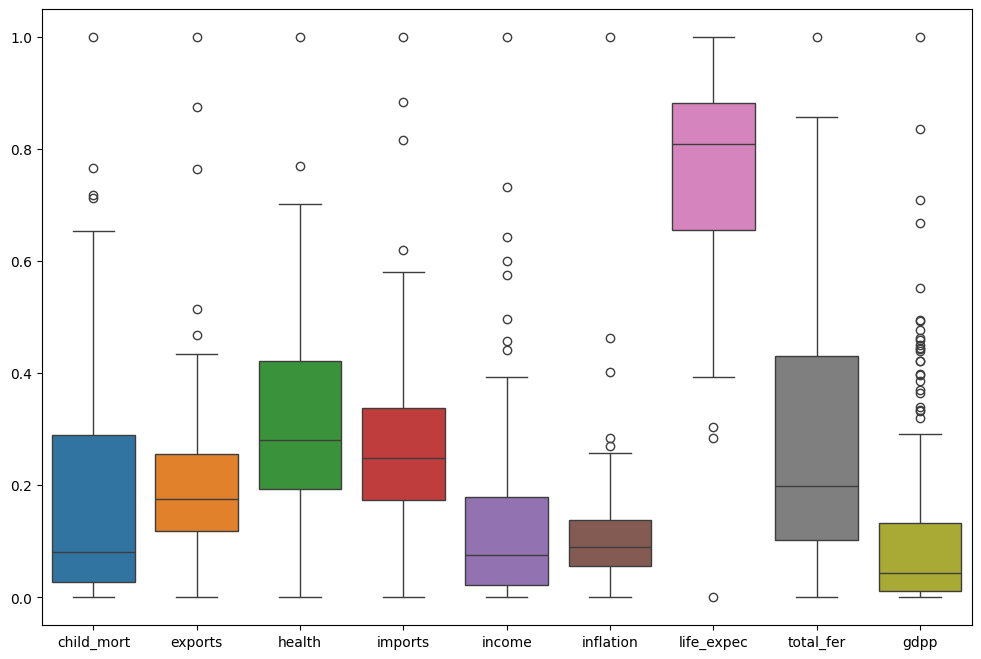

In [804]:
plt.figure(figsize=(12,8))
sns.boxplot(df)
plt.show()

In [805]:
df['gdpp'].value_counts().sort_values(ascending=False)

gdpp
0.010299    4
0.005030    2
0.084367    2
0.024807    2
0.126650    2
           ..
0.369088    1
0.459764    1
0.111378    1
0.010967    1
0.011731    1
Name: count, Length: 157, dtype: int64

In [806]:
# df = df[df['gdpp'].isin(df['gdpp'].value_counts()[df['gdpp'].value_counts() >= 2].index)]

In [807]:
# sns.boxplot(x=df['gdpp'])

## Chosing Best 4 features in varince

In [808]:
df.var().sort_values(ascending=False)

total_fer     0.057015
child_mort    0.038551
life_expec    0.030768
gdpp          0.030605
health        0.029144
income        0.024019
imports       0.019373
exports       0.018806
inflation     0.009543
dtype: float64

In [809]:
cols = ['gdpp' , 'inflation' , 'exports' , 'income']

In [810]:
pca = PCA(n_components=2)
X_train = pca.fit_transform(df[cols])
X_train = pd.DataFrame(X_train , columns=['x1','x2'])

In [811]:
X_train

,x1,x2
0,-0.216289,-0.085441
1,-0.115163,-0.025674
2,-0.089473,0.026512
3,-0.093387,0.150919
4,0.017958,0.016621
...,...,...
162,-0.122602,0.069142
163,-0.055043,-0.032563
164,-0.088950,0.197358
165,-0.173658,0.011616


In [812]:
score = -1
best_k = -1
for i in range(2,11):
    km = KMeans(n_clusters=i)
    y_pred = km.fit_predict(X_train)
    temp = silhouette_score(X_train,y_pred)
    if temp >= score:
        score = temp
        best_k = i

In [813]:
print("Best Score:" , score , "With N:" , best_k)

Best Score: 0.6180475065400771 With N: 2


In [814]:
km = KMeans(n_clusters=2 , random_state=42)
km.fit(X_train)

KMeans(n_clusters=2, random_state=42)

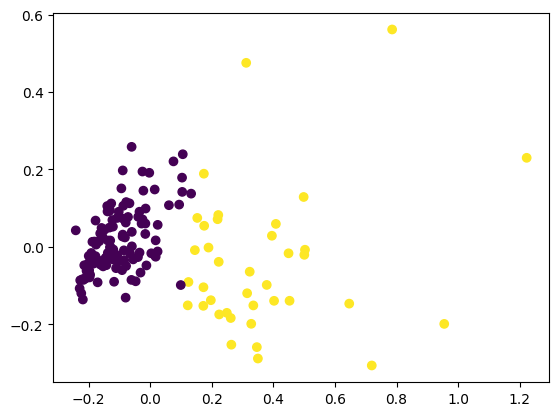

In [815]:
plt.scatter(X_train['x1'] , X_train['x2'] , c = km.labels_)

## Try Fit On all Data

In [816]:
pca = PCA(n_components=2)
x = pca.fit_transform(df)

In [817]:
score = -1
best_k = -1
for i in range(2,11):
    km = KMeans(n_clusters=i)
    y_pred = km.fit_predict(x)
    temp = silhouette_score(x,y_pred)
    if temp >= score:
        score = temp
        best_k = i

In [818]:
score , best_k

(np.float64(0.5323417849942664), 2)

## Try Fit on 2 Columns Only

In [819]:
score = -1
best_k = -1
for i in range(2,11):
    km = KMeans(n_clusters=i)
    y_pred = km.fit_predict(df[['inflation','gdpp']])
    temp = silhouette_score(df[['inflation','gdpp']],y_pred)
    if temp >= score:
        score = temp
        best_k = i

In [820]:
score , best_k

(np.float64(0.6928044297859629), 3)

In [821]:
km = KMeans(n_clusters=3)
km.fit(df[['inflation','gdpp']])

KMeans(n_clusters=3)

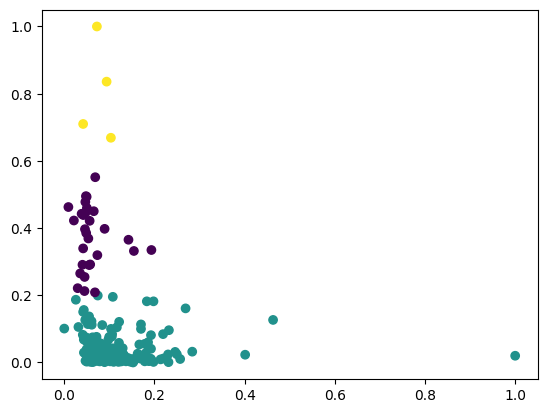

In [822]:
plt.scatter(df['inflation'] , df['gdpp'] , c = km.labels_)

## Try 4 columns have high corr between them

In [823]:
col  = df[['total_fer' , 'child_mort' , 'income' , 'exports']]

In [824]:
score = -1
best_k = -1
for i in range(2,11):
    km = KMeans(n_clusters=i)
    y_pred = km.fit_predict(col)
    temp = silhouette_score(col,y_pred)
    if temp >= score:
        score = temp
        best_k = i

In [825]:
score , best_k

(np.float64(0.5301938759503897), 2)

## Trying every 2 colums

In [826]:
pairs = list(combinations(df , 2))

In [827]:
len(pairs)

36

In [828]:
score = -1
best_k = -1
col1 , col2 = "",""
for f1,f2 in pairs:
    for i in range(2,11):
        km = KMeans(n_clusters=i , random_state=42)
        y_pred = km.fit_predict(df[[f1,f2]])
        temp = silhouette_score(df[[f1,f2]] , y_pred)
        if temp >= score:
            score = temp
            best_k = i
            col1 = f1
            col2 = f2

In [829]:
score

np.float64(0.7552787579283603)

In [830]:
best_k

2

In [831]:
col1

'inflation'

In [832]:
col2

'life_expec'

In [833]:
km = KMeans(n_clusters=2,random_state=42)
km.fit(df[['inflation' , 'life_expec']])

KMeans(n_clusters=2, random_state=42)

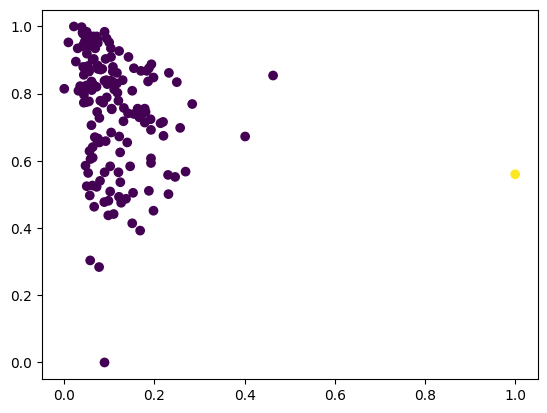

In [834]:
plt.scatter(df['inflation'] , df['life_expec'] , c=km.labels_)

## Try get country with

In [835]:
df = pd.read_csv('Country-data.csv')

In [836]:
c = df['country']

In [837]:
sc = MinMaxScaler()
df_scaled = sc.fit_transform(df.select_dtypes(exclude='object'))
df = pd.DataFrame(df_scaled , columns=df.select_dtypes(exclude='object').columns)

In [838]:
df['country'] = c

In [839]:
la = LabelEncoder()
df['country'] = la.fit_transform(df['country'])

In [840]:
score = -1
best_k = -1
for i in range(2,11):
    km = KMeans(n_clusters=i)
    y_pred = km.fit_predict(df)
    temp = silhouette_score(df,y_pred)
    if temp >= score:
        score = temp
        best_k = i

In [841]:
score*100 , best_k

(np.float64(62.197121037349625), 2)

In [842]:
km = KMeans(n_clusters=2 , random_state=42)
km.fit(df)

KMeans(n_clusters=2, random_state=42)

In [843]:
pca = PCA(n_components=2)
x = pca.fit_transform(df)

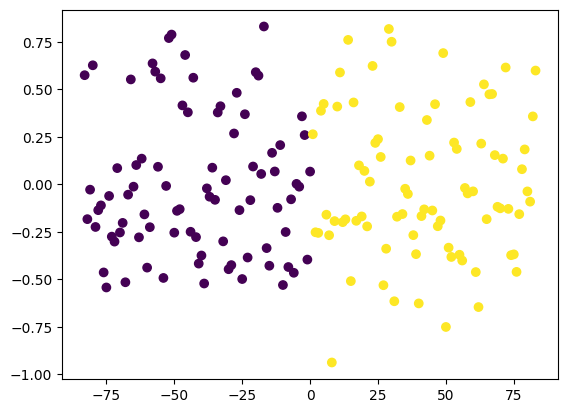

In [844]:
plt.scatter(x[:,0] , x[:,1],c=km.labels_)